In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [24]:
import cv2
import numpy as np

# Input: cv2 image
# Output: binary image
# Remove backgroud; leave only gates
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.inRange(img, (20, 60, 20), (150, 255, 255))
    img = sides(img)

    return img

# Input: cv2 image
# Add black borders to the image
# Fill sides with partial gates with white to make them whole
def sides(img):
    img = cv2.copyMakeBorder(img, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=0)
    # Top
    if np.any(img[100:-101, 100]):
        img[:, :100] = 255
    # Bottom
    if np.any(img[100:-101, -101]):
        img[:, -101:] = 255
    # Left
    if np.any(img[100, 100:-101]):
        img[:100, :] = 255
    #Right
    if np.any(img[-101, 100:-101]):
        img[-101:, :] = 255
    
    return img

# Input: cv2 image
def find_largest_contour_with_child(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find contours with children
    cont_arr = []
    for i, cont in enumerate(contours):
        # Has children?
        if hierarchy[0, i, 2] > -1:
            cont_arr.append(cont)
    
    if len(cont_arr) == 0:
        return []

    # Calculate contour sizes
    sizes = []
    for cont in cont_arr:
        sizes.append(cv2.contourArea(cont))

    # Largest contour
    largest = cont_arr[np.argmax(sizes)]
    return largest

# Input: cv2 contour
# Test if contour is close enough to convex
def test_convexity(cont):
    
    hull = cv2.convexHull(cont,returnPoints = False)
    hull_points = cv2.convexHull(cont,returnPoints = True)
    defects = cv2.convexityDefects(cont,hull)
    convexity_threshold = 0.03 * cv2.arcLength(hull_points, closed=True)

    if  defects is None:
        return True
    
    # Approximate distance to farhest point from convex hull
    # More info: https://docs.opencv.org/4.x/d5/d45/tutorial_py_contours_more_functions.html
    farthest =  defects[:, :, 3]/256.0
    farthest = farthest.flatten()

    for dist in farthest:
        if dist > convexity_threshold:
            return False

    return True

# Input: (cv2) binary image
# Output: (cv2) binary image, number of erosions
# Erode the image until the closest gate is separated from other gates
# and the pole is gone
def sep_closest_gate(img):
    # Erosion kernel
    kernel = np.ones((2,2),np.uint8)
    test_img = img.copy()

    index = 0
    # For loop instead of while to prevent looping too long
    for i in range(100):
        test_img = cv2.erode(test_img, kernel, iterations = 1)
        cont = find_largest_contour_with_child(test_img)

        # No contours with child left?
        if len(cont) == 0:
            index = i
            break
        elif test_convexity(cont):
            index = i + 1
            break
    
    # Erode the actual image one less time to keep the gate whole
    for i in range(index):
        img = cv2.erode(img, kernel, iterations = 1)
       
    return img, index

# Input: cv2 contour
# Output: bounding rectangle
def get_b_rect(cont, img_dims, erosions):
    if len(cont) == 0:
        return -1, -1, -1, -1
    else:
        x,y,w,h = cv2.boundingRect(cont)
        # Account for erosion
        x = x - (100 + erosions)
        y = y - (100 + erosions)
        w = w + erosions
        h = h + erosions

        if w > img_dims[1] or h > img_dims[0]:
            w = 100
            h = 100

            M = cv2.moments(cont)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            x = cX - 50
            y = cY - 50

        # Fix out-of-bounds rectangles
        if x < 0:
            x = 0

        if y < 0:
            y = 0
        
        if x + w > img_dims[1]:
            #w = w - (x + w - img_dims[0])
            w = img_dims[1] - x

        if y + h > img_dims[0]:
            #w = w - (x + w - img_dims[0])
            h = img_dims[0] - y

        return x, y, w, h
    
# Input: cv2 image
# Output: bounding rectangle of closest gate
def get_closest_gate(img):
    img_dims = img.shape
    img = preprocess(img)
    img, erosions = sep_closest_gate(img)
    cont = find_largest_contour_with_child(img)
    return get_b_rect(cont, img_dims, erosions)



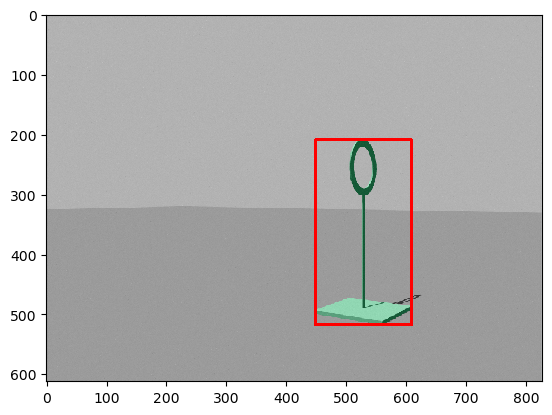

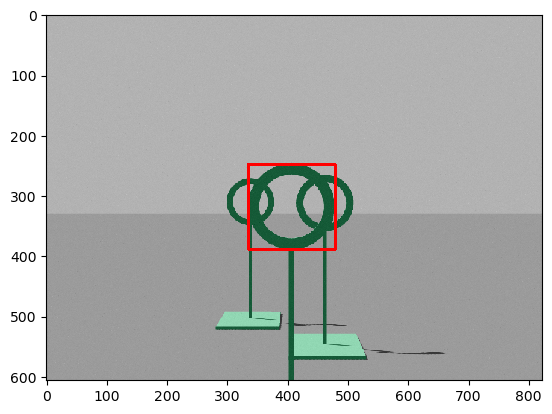

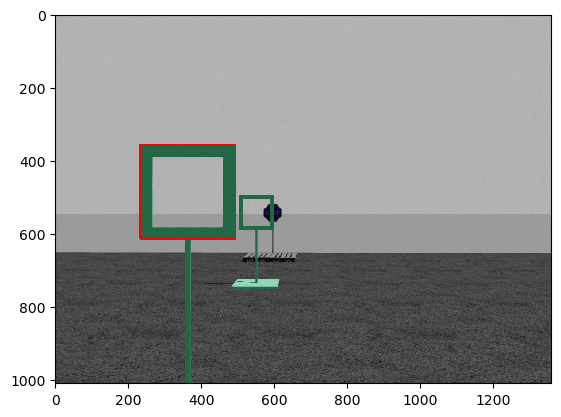

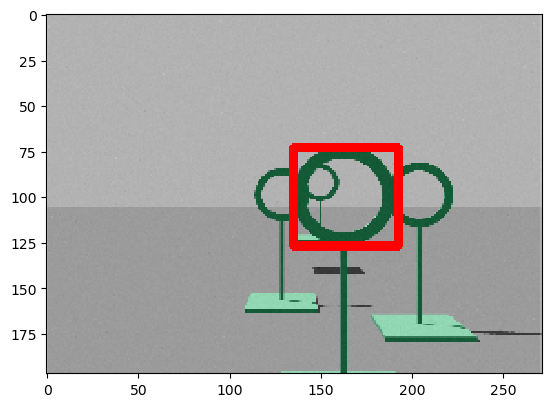

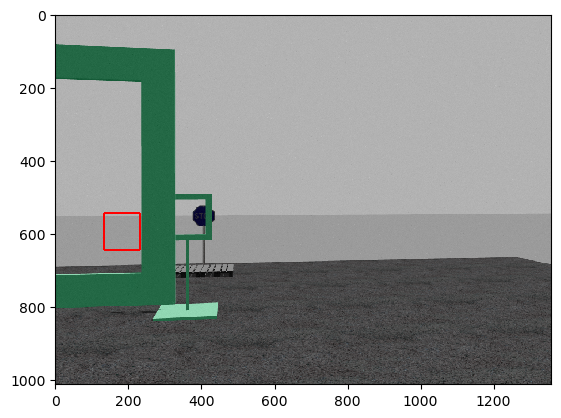

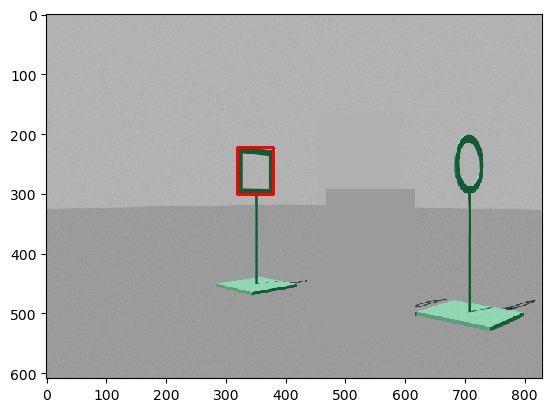

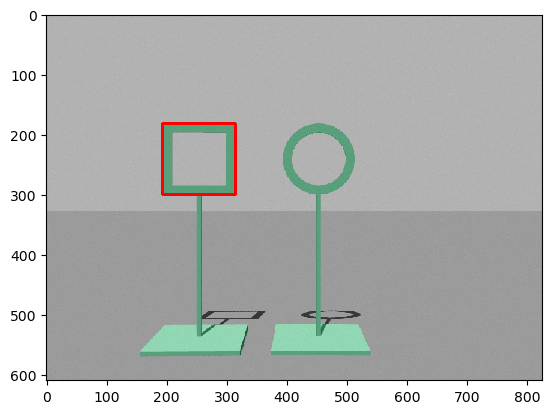

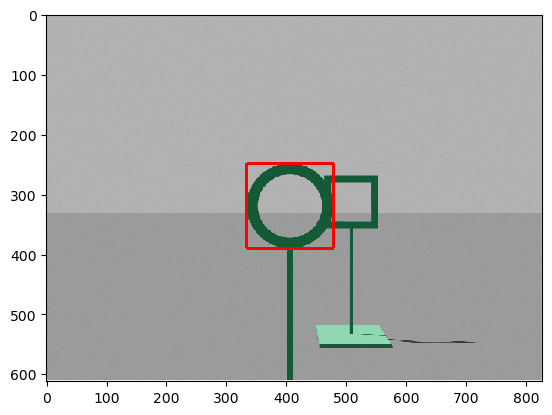

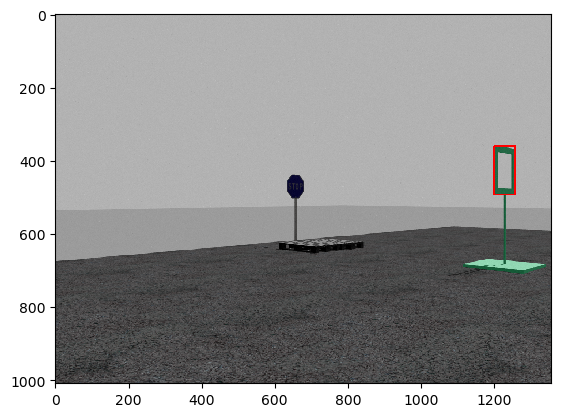

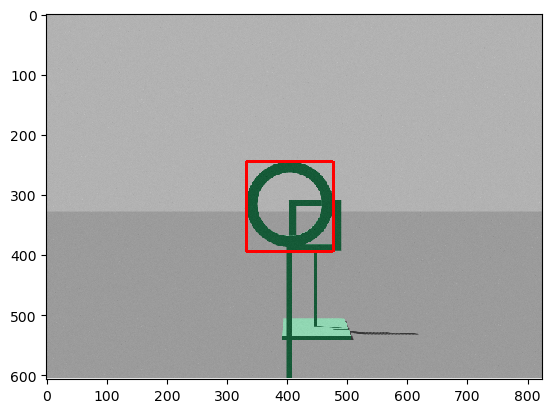

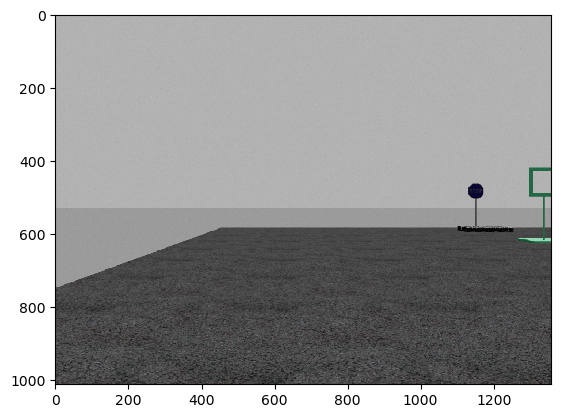

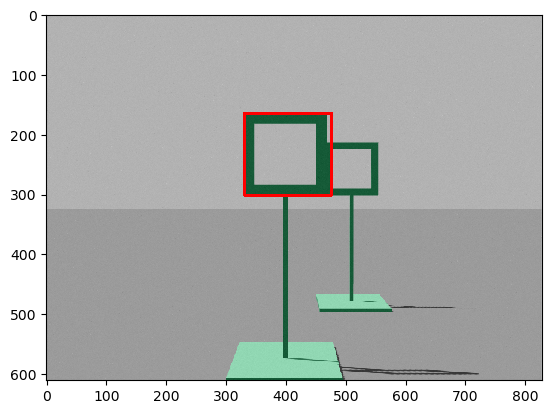

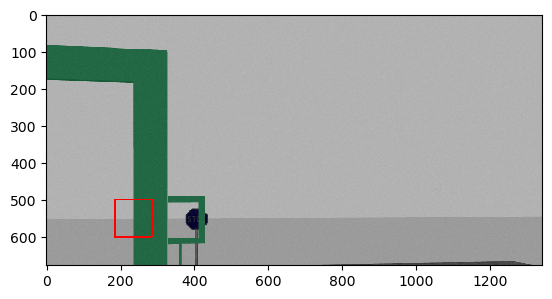

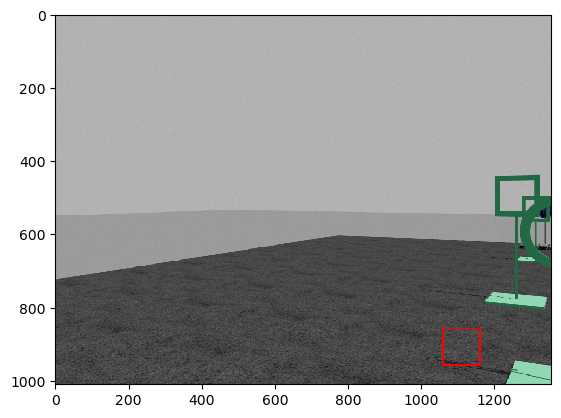

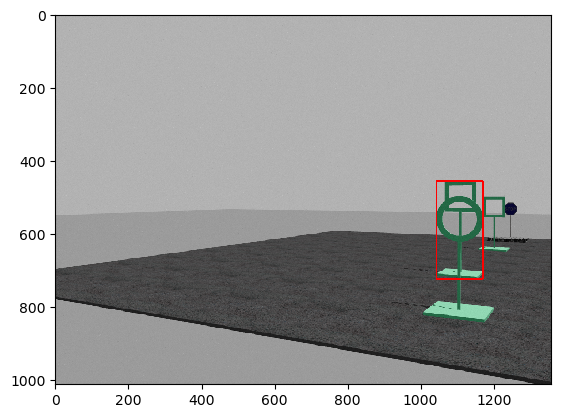

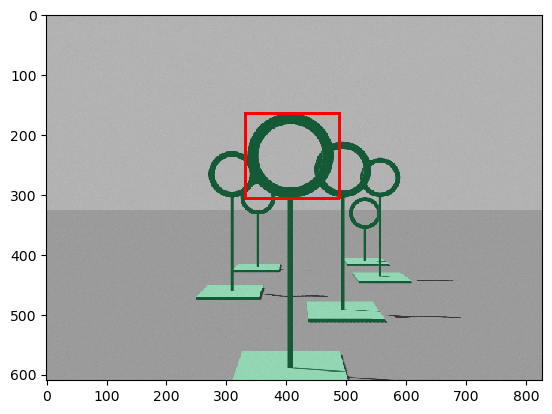

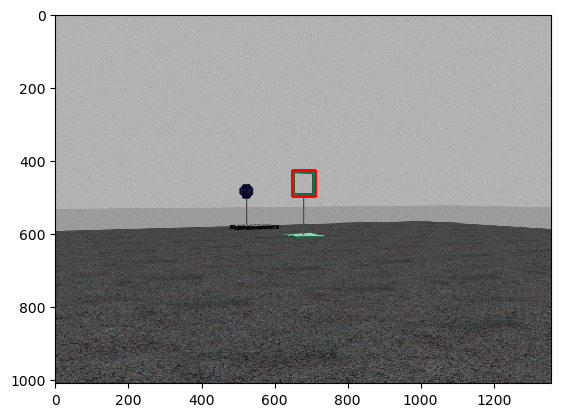

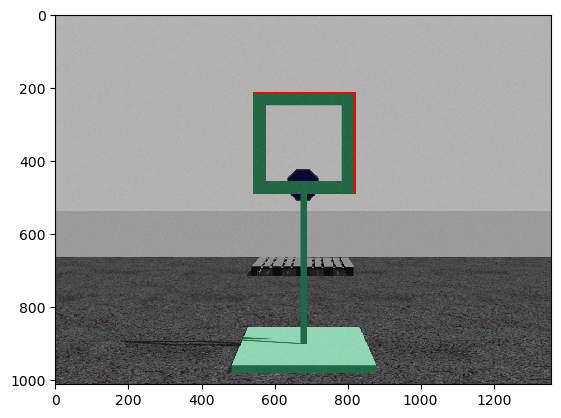

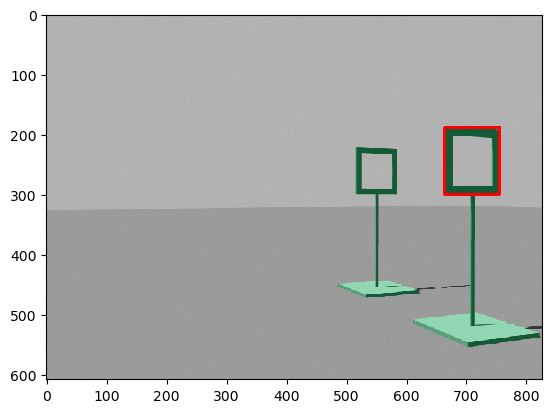

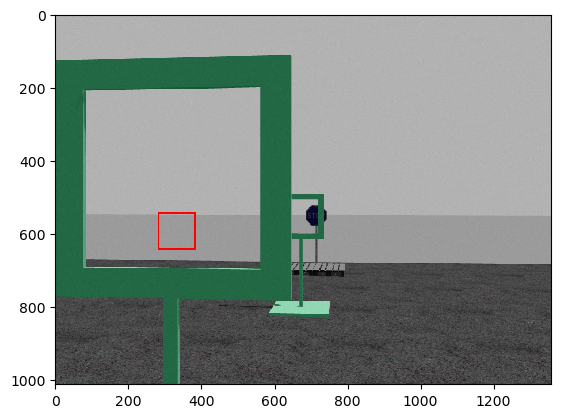

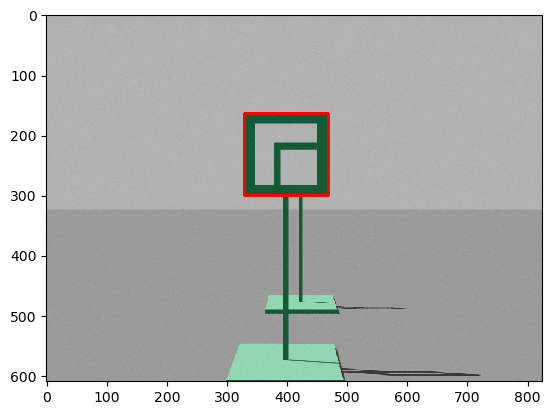

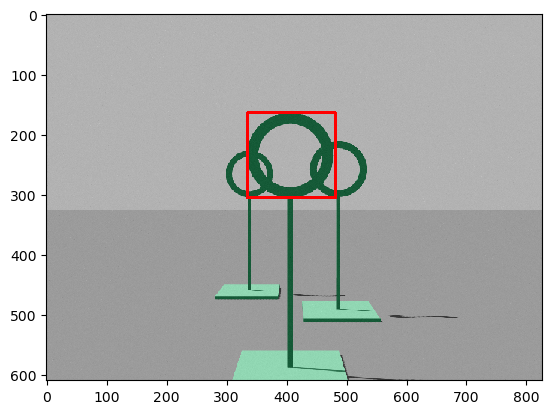

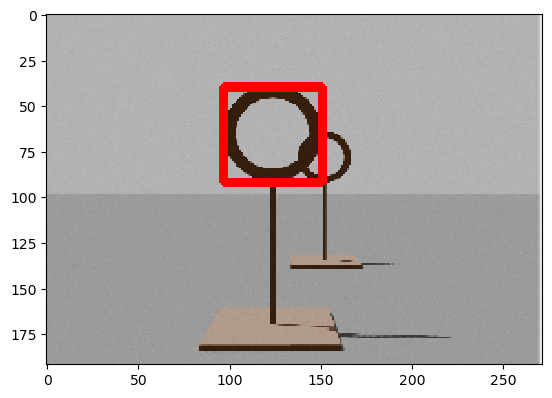

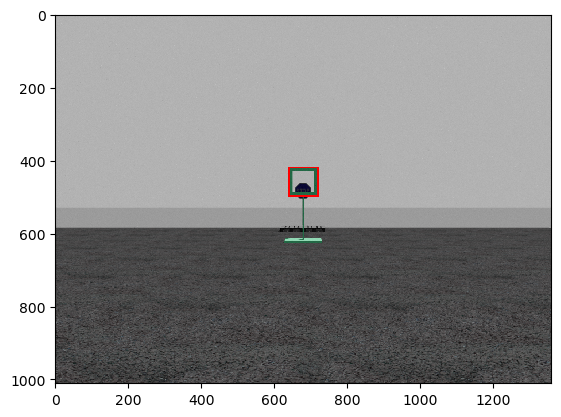

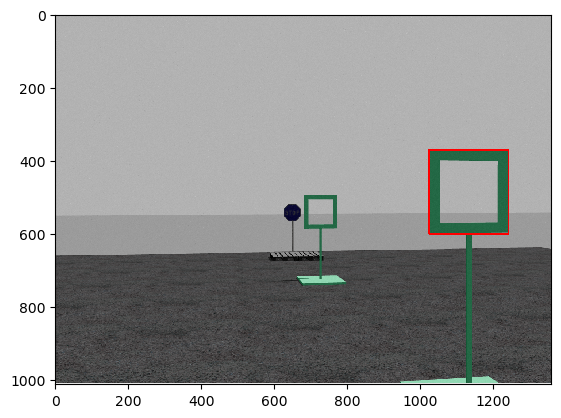

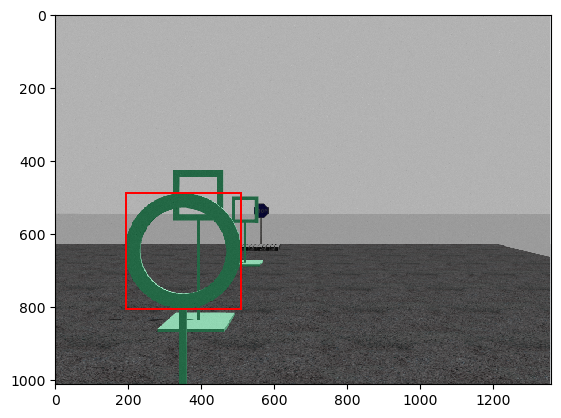

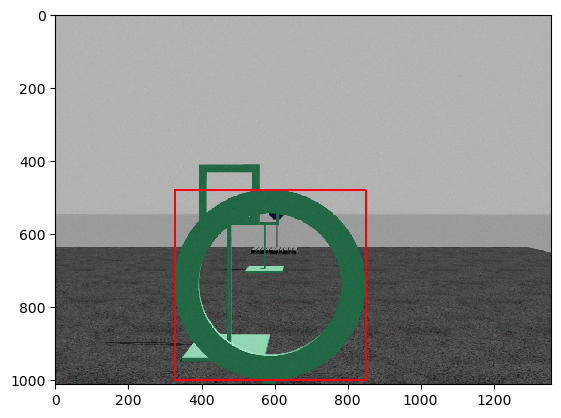

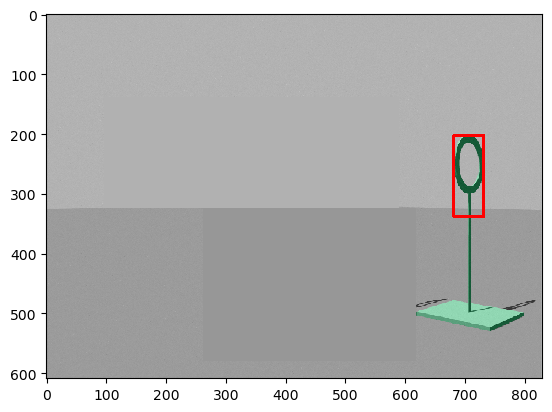

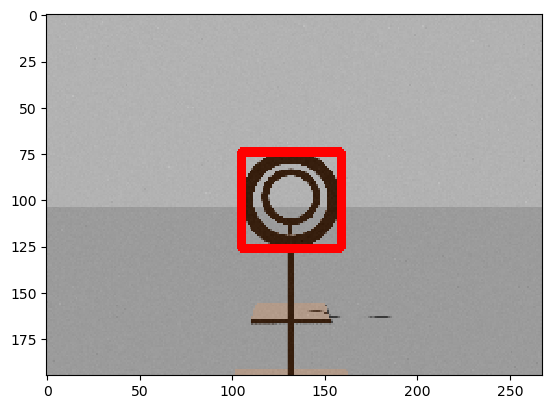

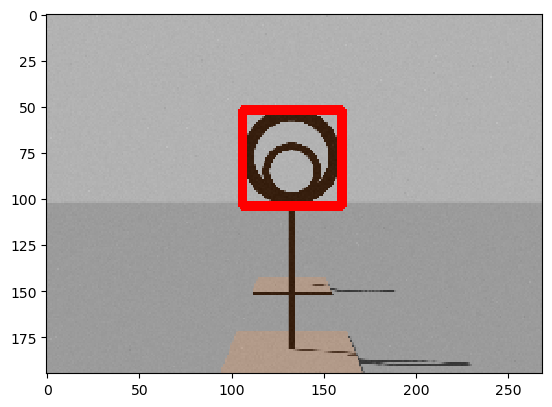

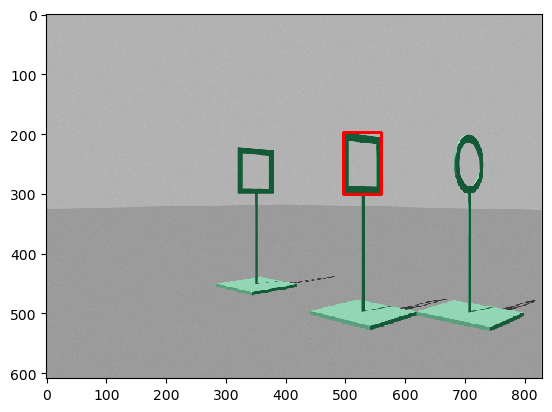

In [25]:

for filename in os.listdir('images'):
    f = os.path.join('images', filename)
    img = cv2.imread(f)
    x, y, w, h = get_closest_gate(img)
    img = cv2.rectangle(img, (x, y),(x + w, y + h), color=(255, 0, 0), thickness=3)
    plt.imshow(img)
    plt.show()